<a href="https://www.kaggle.com/code/layonsan/spaceship-titanic-with-tensorflow-decision-forests?scriptVersionId=153544778" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# TensorFlow Decision Forest Notebook

This notebook serves to illustrate the following items:
1. Simple exploratory data analysis on the training dataset
2. Preprocessing to prepare the data
3. Classification using TensorFlow DecisioN Forest with Random Forest and Gradient Boosted 

This notebook was spun off from [gusthema's tensorflow starter notebook](https://www.kaggle.com/code/gusthema/spaceship-titanic-with-tfdf).

Notably, the main additions will be more preprocessing of data and a more elaborate usage of TensorFlow Decision Forest models with auto-tuning of hyperparameters.

## We will import the necessary libraries and load the dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
print("Pandas" + pd.__version__)
print("Numpy" + np.__version__)
print("Seaborn" + sns.__version__)

Pandas1.3.5
Numpy1.21.6
Seaborn0.12.2


In [3]:
# load raw dataset
# Load a dataset into a Pandas Dataframe
train_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
print("Full train dataset shape is {}".format(train_df.shape))

Full train dataset shape is (8693, 14)


In [4]:
# Display the first 5 examples
train_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## EDA

Let us quickly do a basic exploration of the dataset

In [5]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


### Bar chart for label column: Transported

<AxesSubplot:>

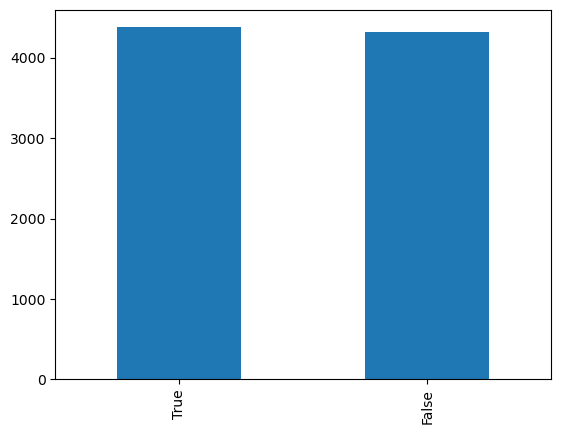

In [7]:
train_df.Transported.value_counts().plot(kind="bar")

There does not appear to be a class imbalance problem for the predicted labels.

# Prepare the dataset

We will clean and transform the data set to prepare the data for using TensorFlow.

In [8]:
# numerical features
num_feats = ['FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','RoomService']

# boolean features
bool_lst = ["Transported","CryoSleep","VIP"]

# categorical features
cat_feats = ['VIP','CryoSleep', 'HomePlanet','Cabin_num','Destination','Deck','Side']

We will drop `Name` column as they are not necessary for model training.

In [9]:
train_df = train_df.drop(['Name'], axis=1)
train_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [10]:
train_df.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

This dataset contains a mix of numeric, categorical and missing features. Boolean fields have missing values too. So we need to convert those fields into int. To account for the missing values in the boolean fields, we will replace them with zero.

## Numerical Features

In [11]:
# filling missing values for numeric features
train_df[num_feats] = train_df[num_feats].fillna(value=0)
train_df.isnull().sum().sort_values(ascending=False)

CryoSleep       217
VIP             203
HomePlanet      201
Cabin           199
Destination     182
Age             179
PassengerId       0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64

### Numerical data distribution

Let us plot all the numerical columns and their value counts:

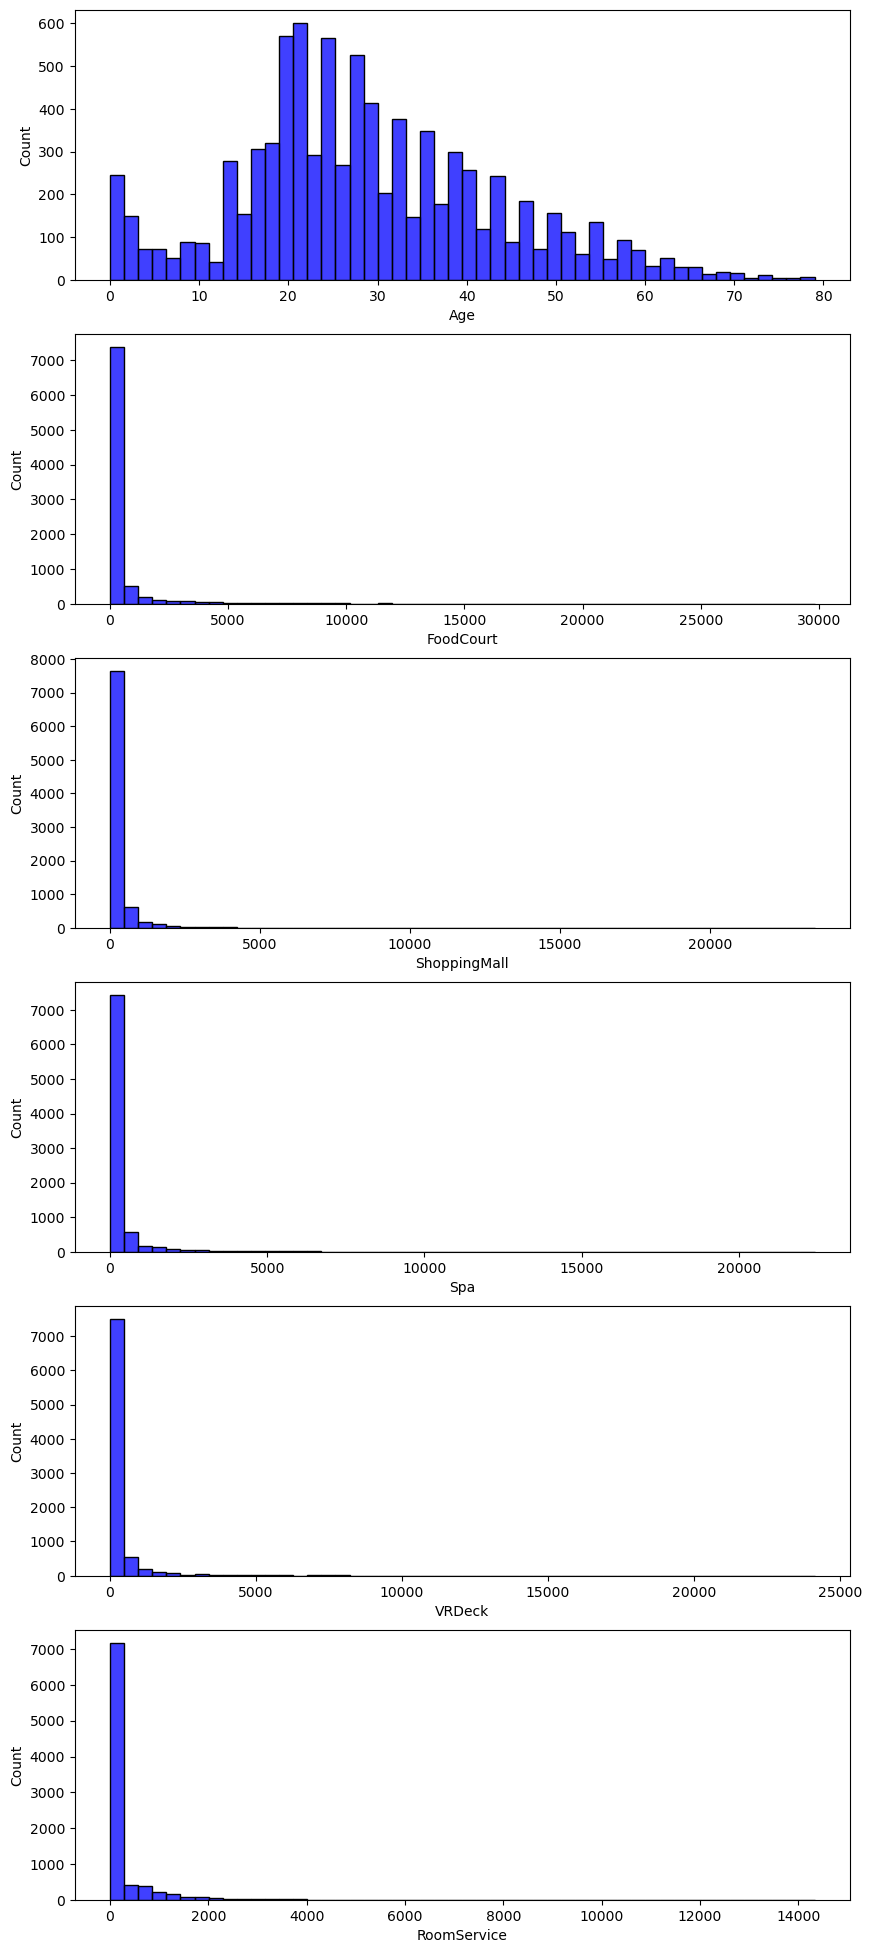

In [12]:
fig, ax = plt.subplots(6,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

# numerical features
num_feats = ['Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','RoomService']

for i in range(len(num_feats)):
    sns.histplot(train_df[num_feats[i]], color='b', bins=50, ax=ax[i]);

## Feature Engineering
- Cabin
- PassengerId

The value of column `Cabin` is a string with the format `Deck/Cabin_num/Side`. Here we will split the `Cabin` column and create 3 new columns `Deck`, `Cabin_num` and `Side`, since it will be easier to train the model on those individual data.

Run the following command to split the column `Cabin` into columns `Deck`, `Cabin_num` and `Side`

In [13]:
train_df["Cabin"].str.split("/", expand=True)

train_df[["Deck", "Cabin_num", "Side"]] = train_df["Cabin"].str.split("/", expand=True)

We can create a new column IsAlone with reference to PassengerID Column.

In [14]:
train_df[['PassengerId_1','PassengerId_2']] = train_df['PassengerId'].str.split('_',expand=True)
train_df['IsAlone'] = (train_df.groupby('PassengerId_1')['PassengerId_2'].transform('max').astype(int) < 2).astype(int)

Remove original `Cabin` column from the dataset since it's not needed anymore.

In [15]:
try:
    train_df = train_df.drop(['Cabin','PassengerId','PassengerId_1','PassengerId_2'], axis=1)
except KeyError:
    print("Field does not exist")

In [16]:
train_df.isnull().sum().sort_values(ascending=False)

CryoSleep       217
VIP             203
HomePlanet      201
Deck            199
Cabin_num       199
Side            199
Destination     182
Age             179
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
IsAlone           0
dtype: int64

## Categorical Features

### Age - Bin `age` into `age groups`

In [17]:
# fill age with mean
train_df['Age'] = train_df['Age'].fillna(value=train_df['Age'].mean())

# create age group from age
train_df['AgeGroup'] = train_df['Age'].apply(lambda x: int(str(x)[0]) if x > 10 else 0) 

# drop age
train_df = train_df.drop(['Age'],axis=1)

In [18]:
train_df.isnull().sum().sort_values(ascending=False)

CryoSleep       217
VIP             203
HomePlanet      201
Deck            199
Cabin_num       199
Side            199
Destination     182
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
IsAlone           0
AgeGroup          0
dtype: int64

We will impute missing values for categorical features with mode

In [19]:
train_df[cat_feats] = train_df[cat_feats].fillna(value=train_df.mode().iloc[0])

## Boolean Features

In [20]:
def convert_bool_to_int (df:pd.DataFrame, col_lst:list)->pd.DataFrame:
    """
    Simple utility function to convert column from boolean values to integer format. Some ML models are not able to accept boolean values.
    
    Args:
        df [pandas dataframe]: dataframe in pandas format
        col_lst [list]: list of column names in boolean format to be converted to int 
        
    Return:
        df [pandas dataframe]: dataframe in pandas format with boolean columns converted to int
    """
    
#     run tests to verify if there are null values in the boolean columns since columns with null values cannot be converted to int
    target_df = df[col_lst] # create new dataframe with only boolean columns
    test_result = any(num > 0 for num in list(target_df.isnull().sum())) # check if column have null values
    
    # convert boolean to int if there are no null values
    if test_result == False: 
        for col in col_lst:
            df[col] = df[col].astype(int)
        
    else:
        print("There are null values in the columns. Dataframe remains unchanged")
        
    return df

In [21]:
train_df = convert_bool_to_int(train_df, bool_lst)

train_df.head()

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,IsAlone,AgeGroup
0,Europa,0,TRAPPIST-1e,0,0.0,0.0,0.0,0.0,0.0,0,B,0,P,1,3
1,Earth,0,TRAPPIST-1e,0,109.0,9.0,25.0,549.0,44.0,1,F,0,S,1,2
2,Europa,0,TRAPPIST-1e,1,43.0,3576.0,0.0,6715.0,49.0,0,A,0,S,0,5
3,Europa,0,TRAPPIST-1e,0,0.0,1283.0,371.0,3329.0,193.0,0,A,0,S,0,3
4,Earth,0,TRAPPIST-1e,0,303.0,70.0,151.0,565.0,2.0,1,F,1,S,1,1


### Categorical data distribution

Let us plot all the categorical columns and their value counts:

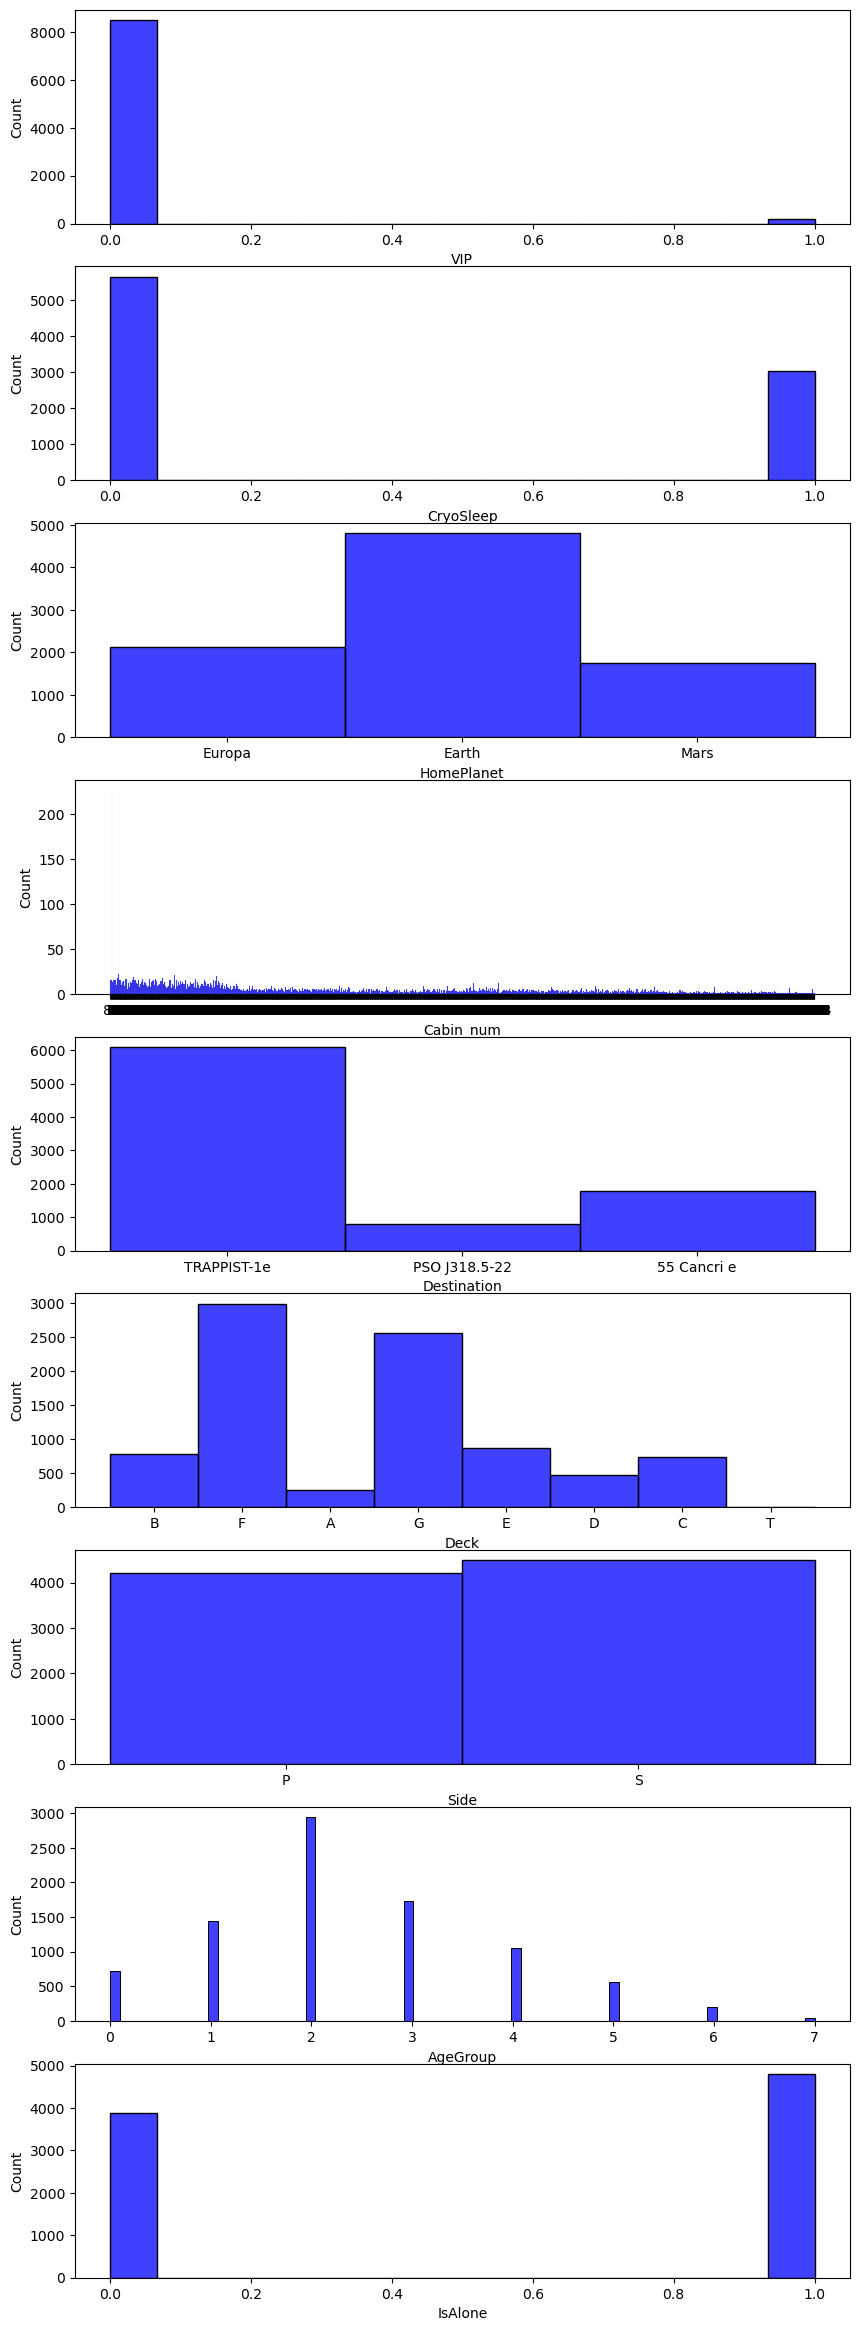

In [22]:
fig, ax = plt.subplots(9,1,  figsize=(10, 12))
plt.subplots_adjust(top = 2)

cat_feats = ['VIP','CryoSleep', 'HomePlanet','Cabin_num','Destination','Deck','Side','AgeGroup','IsAlone']

for i in range(len(cat_feats)):
    sns.histplot(train_df[cat_feats[i]], color='b', ax=ax[i]);

In [23]:
train_df.isnull().sum().sort_values(ascending=False)

HomePlanet      0
CryoSleep       0
Destination     0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Deck            0
Cabin_num       0
Side            0
IsAlone         0
AgeGroup        0
dtype: int64

All features have been imputed with values. Our data has been successfully preprocessed.

## Preprocess test dataset

We will consolidate the preprocessing codes into a single function to perform the set set of preprocessing on the test dataset

In [24]:
def preprocessing (df):
    """
    Requires the function - convert_bool_to_int 

    Args:
        df [pandas dataframe]: pandas dataframe

    Returns:
        df [pandas dataframe]: pandas dataframe

    """

    # declare numerical and categorical features
    num_feats = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    
    # filling missing values for numeric features
    df[num_feats] = df[num_feats].fillna(value=0)

    ## feature engineering
    # split cabin columns
    df["Cabin"].str.split("/", expand=True)

    df[["Deck", "Cabin_num", "Side"]] = df["Cabin"].str.split("/", expand=True)
    
    # create IsAlone column
    df[['PassengerId_1','PassengerId_2']] = df['PassengerId'].str.split('_',expand=True)
    df['IsAlone'] = (df.groupby('PassengerId_1')['PassengerId_2'].transform('max').astype(int) < 2).astype(int)

    # fill age with mean
    df['Age'] = df['Age'].fillna(value=df['Age'].mean())

    # create age group from age
    df['AgeGroup'] = df['Age'].apply(lambda x: int(str(x)[0]) if x > 10 else 0) 

    # new categorical features based on feature engineering
    cat_feats = ['VIP', 'CryoSleep', 'HomePlanet','Cabin_num','Destination','Deck','Side']

    # impute missing values with mode
    df[cat_feats] = df[cat_feats].fillna(value=df.mode().iloc[0])
    
    # convert boolean to list
    bool_lst = ["VIP","CryoSleep"]

    # this line uses a separate function declared outside of this function
    df = convert_bool_to_int(df, bool_lst)

    # drop unnecessary columns
    try:
        df = df.drop(['Cabin','Age','Name','PassengerId','PassengerId_1','PassengerId_2'], axis=1)
    except KeyError:
        print("Field does not exist")

    return df

In [25]:
# Load a dataset into a Pandas Dataframe
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
print("Full test dataset shape is {}".format(test_df.shape))

submission_id = test_df['PassengerId']

Full test dataset shape is (4277, 13)


In [26]:
test_df = preprocessing(test_df)

Both training and test data set have been preprocessed for further model experimentation.

In [27]:
train_df.head()

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,IsAlone,AgeGroup
0,Europa,0,TRAPPIST-1e,0,0.0,0.0,0.0,0.0,0.0,0,B,0,P,1,3
1,Earth,0,TRAPPIST-1e,0,109.0,9.0,25.0,549.0,44.0,1,F,0,S,1,2
2,Europa,0,TRAPPIST-1e,1,43.0,3576.0,0.0,6715.0,49.0,0,A,0,S,0,5
3,Europa,0,TRAPPIST-1e,0,0.0,1283.0,371.0,3329.0,193.0,0,A,0,S,0,3
4,Earth,0,TRAPPIST-1e,0,303.0,70.0,151.0,565.0,2.0,1,F,1,S,1,1


In [28]:
test_df.head()

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Cabin_num,Side,IsAlone,AgeGroup
0,Earth,1,TRAPPIST-1e,0,0.0,0.0,0.0,0.0,0.0,G,3,S,1,2
1,Earth,0,TRAPPIST-1e,0,0.0,9.0,0.0,2823.0,0.0,F,4,S,1,1
2,Europa,1,55 Cancri e,0,0.0,0.0,0.0,0.0,0.0,C,0,S,1,3
3,Europa,0,TRAPPIST-1e,0,0.0,6652.0,0.0,181.0,585.0,C,1,S,1,3
4,Earth,0,TRAPPIST-1e,0,10.0,0.0,635.0,0.0,0.0,F,5,S,1,2


# Tensorflow Decision Trees

We will now use Random Forest and Gradient Boosted Trees from TensorFlow  

In [29]:
import tensorflow_decision_forests as tfdf

np.random.seed(1234)  # reproducible plots/data for explanatory reasons


In [30]:
# Let's check the versions:
tfdf.__version__

'1.2.0'

In [31]:
# define label
label = 'Transported'

classes = list(train_df[label].unique())

print(f"Target '{label}'' classes: {classes}")

Target 'Transported'' classes: [0, 1]


We will split the training data into training and validation data sets.

In [32]:
def split_dataset(df, test_ratio=0.20, seed=1234):
  """
  Splits a panda dataframe in two, usually for train/test sets.
  Using the same random seed ensures we get the same split so
  that the description in this tutorial line up with generated images.
  """
  np.random.seed(seed)
  test_indices = np.random.rand(len(df)) < test_ratio
  return df[~test_indices], df[test_indices]

In [33]:
train_df, valid_df = split_dataset(train_df)

In [34]:
# convert pandas df to tensorflow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df,label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df)

# Experimenting with TensorFlow Decision Trees

Models:
- Random Forest (RF)
- Gradient Boosted Trees (GBT)

In [35]:
models = {
    'rf': tfdf.keras.RandomForestModel(verbose=0),
    'gbt': tfdf.keras.GradientBoostedTreesModel(verbose=0)
}

In [36]:
for model_name, model in models.items():
    print(f"Experimenting with {model_name}")
    model = model
    model.fit(train_ds)
    
    model.compile(metrics=["accuracy"]) # Optional, you can use this to include a list of eval metrics
    evaluation = model.evaluate(valid_ds, return_dict=True, verbose=1)
    for name, value in evaluation.items():
        print(f"{name}: {value:.4f}")
        
    print(f"Completed experiment with {model_name}")

Experimenting with rf


[INFO 2023-12-04T09:47:39.645010776+00:00 kernel.cc:1214] Loading model from path /tmp/tmpjwx9ae7x/model/ with prefix 6f5567e257944d5c
[INFO 2023-12-04T09:47:40.296340412+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 237720 node(s), and 14 input feature(s).
[INFO 2023-12-04T09:47:40.296394671+00:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-12-04T09:47:40.296438762+00:00 kernel.cc:1046] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 [==============================] - 0s 52ms/step - loss: 0.0000e+00 - accuracy: 0.8034
loss: 0.0000
accuracy: 0.8034
Completed experiment with rf
Experimenting with gbt


[INFO 2023-12-04T09:48:13.196388986+00:00 kernel.cc:1214] Loading model from path /tmp/tmpbwdkkrpd/model/ with prefix 0b54149f85de418e
[INFO 2023-12-04T09:48:13.204670307+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2023-12-04T09:48:13.204693307+00:00 kernel.cc:1046] Use fast generic engine


2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8028
loss: 0.0000
accuracy: 0.8028
Completed experiment with gbt


Without any further improvements to the model, the baseline comparison between Random Forest (RF) and Gradient Boosted Trees (GBT) shows that RF performed slightly better than GBT. 

### Auto Hyperparameter tuning for Random Forest Trees Classifier

Let's train a RF model with automated hyper-parameter tuning and automatic definition of the hyper-parameters

In [37]:
# configure auto tuner
# Create a Random Search tuner with 50 trials and automatic hp configuration.
rf_tuner = tfdf.tuner.RandomSearch(num_trials=50, use_predefined_hps=True)

# Define and train the model.
rf_auto = tfdf.keras.RandomForestModel(tuner=rf_tuner)
rf_auto.fit(train_ds,  verbose=1)

rf_auto.compile(metrics=["accuracy"])
rf_auto.evaluate(valid_ds, return_dict=True, verbose=0)

Use /tmp/tmp7na6_aqo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.249035. Found 6903 examples.
Training model...


[INFO 2023-12-04T10:31:26.523924036+00:00 kernel.cc:1214] Loading model from path /tmp/tmp7na6_aqo/model/ with prefix 79419155244542c3


Model trained in 0:43:01.710753
Compiling model...


[INFO 2023-12-04T10:31:26.909408537+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 142462 node(s), and 14 input feature(s).
[INFO 2023-12-04T10:31:26.909469797+00:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-12-04T10:31:26.909493957+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.


{'loss': 0.0, 'accuracy': 0.7966480255126953}

Auto-tuning of RF model appears to reduce model accuracy instead

In [38]:
# making inspector
rf_auto_inspector = rf_auto.make_inspector()

#### Variable Importance for Auto-tuned RF

In [39]:
print(f"Available variable importances:")
for importance in rf_auto_inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES
	 INV_MEAN_MIN_DEPTH


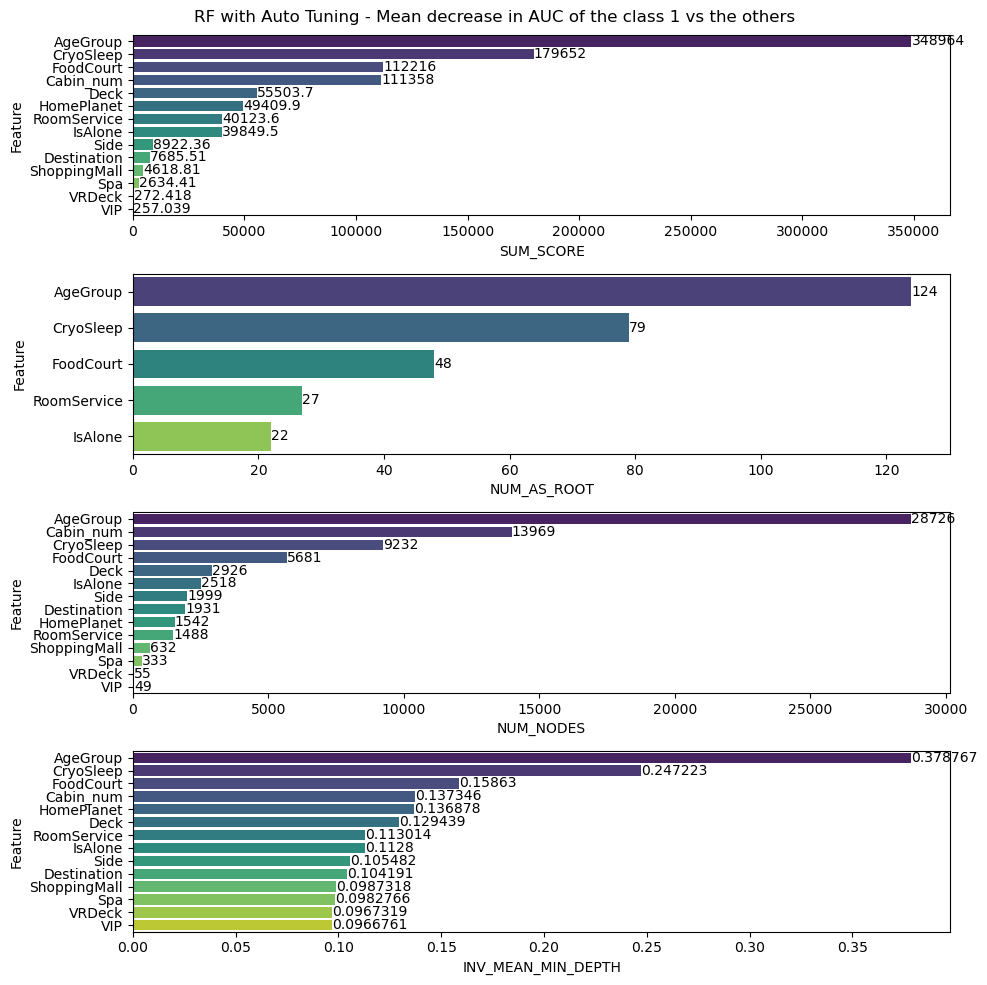

In [40]:
fig, ax = plt.subplots(4,1,  figsize=(10, 10))
fig.suptitle("RF with Auto Tuning - Mean decrease in AUC of the class 1 vs the others")
plt.subplots_adjust(top = 2)

rf_auto_variable_importance_metrics = list(rf_auto_inspector.variable_importances().keys())

for i in range(len(rf_auto_variable_importance_metrics)):
    # for metric in variable_importance_metrics
    rf_auto_variable_importances = rf_auto_inspector.variable_importances()[rf_auto_variable_importance_metrics[i]]
    
    # `variable_importances` is a list of <feature, importance> tuples.
    rf_auto_feature_names = [vi[0].name for vi in rf_auto_variable_importances]
    rf_auto_feature_importances = [vi[1] for vi in rf_auto_variable_importances]
    # The feature are ordered in decreasing importance value.
    rf_auto_feature_ranks = range(len(rf_auto_feature_names))

    # Create a DataFrame to use with seaborn
    rf_auto_importance_df = pd.DataFrame({'Feature': rf_auto_feature_names, 'Importance': rf_auto_feature_importances})

    # Plotting with seaborn barplot
    
    sns.barplot(rf_auto_importance_df, y='Feature',x='Importance', orient='h', palette='viridis', ax=ax[i])
    ax[i].set_xlabel(rf_auto_variable_importance_metrics[i])
    
    # Show the values on bars
    for j in ax[i].containers:
        ax[i].bar_label(j,)
    
plt.tight_layout()
plt.show()

#### Training logs for Auto-tuned RF

Text(0, 0.5, 'Logloss (out-of-bag)')

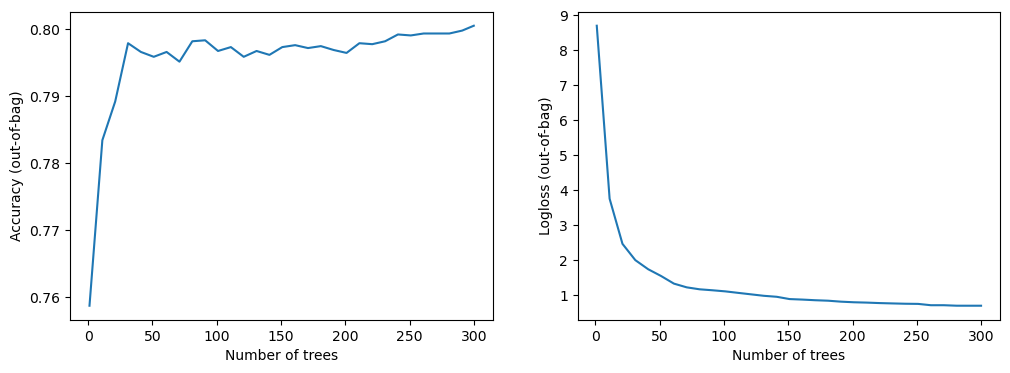

In [41]:
rf_training_logs = rf_auto_inspector.training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in rf_training_logs], [log.evaluation.accuracy for log in rf_training_logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in rf_training_logs], [log.evaluation.loss for log in rf_training_logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

#### Tuning logs for Auto-tuned GBT

In [42]:
# Display the tuning logs.
rf_tuning_logs = rf_auto_inspector.tuning_logs()

rf_tuning_logs.head()

,score,evaluation_time,best,split_axis,sparse_oblique_projection_density_factor,sparse_oblique_normalization,sparse_oblique_weights,categorical_algorithm,winner_take_all,max_depth,min_examples
0,0.796465,196.553202,False,SPARSE_OBLIQUE,5.0,MIN_MAX,BINARY,CART,true,12,40
1,0.791540,222.839023,False,SPARSE_OBLIQUE,4.0,MIN_MAX,CONTINUOUS,RANDOM,true,16,10
2,0.785456,245.216006,False,SPARSE_OBLIQUE,4.0,STANDARD_DEVIATION,BINARY,CART,true,25,2
3,0.794292,245.345350,False,SPARSE_OBLIQUE,5.0,MIN_MAX,CONTINUOUS,CART,true,16,1
4,0.787339,378.853976,False,SPARSE_OBLIQUE,1.0,MIN_MAX,CONTINUOUS,CART,true,20,10


In [43]:
# Best hyper-parameters.
print(rf_tuning_logs[rf_tuning_logs.best].iloc[0])

score                                             0.800521
evaluation_time                                 1001.26199
best                                                  True
split_axis                                  SPARSE_OBLIQUE
sparse_oblique_projection_density_factor               4.0
sparse_oblique_normalization                          NONE
sparse_oblique_weights                          CONTINUOUS
categorical_algorithm                               RANDOM
winner_take_all                                       true
max_depth                                               12
min_examples                                             1
Name: 17, dtype: object


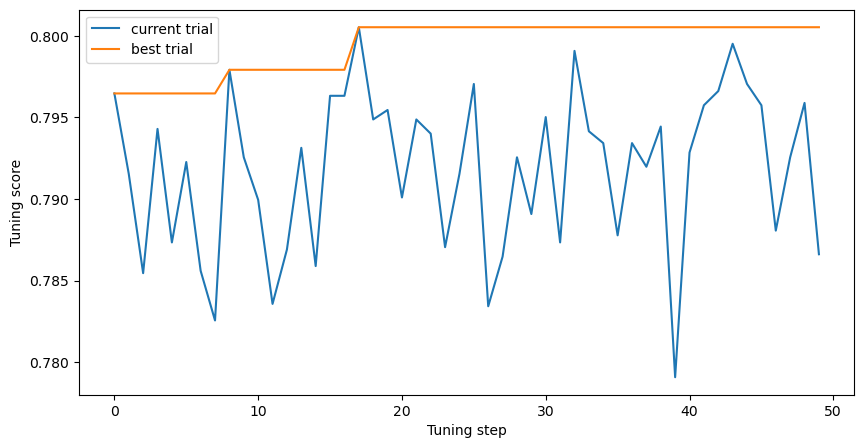

In [44]:
# plots
plt.figure(figsize=(10, 5))
plt.plot(rf_tuning_logs["score"], label="current trial")
plt.plot(rf_tuning_logs["score"].cummax(), label="best trial")
plt.xlabel("Tuning step")
plt.ylabel("Tuning score")
plt.legend()
plt.show()

### Auto Hyperparameter tuning for Gradient Boosted Trees

Let's training a GBT model with automated hyper-parameter tuning and automatic definition of the hyper-parameters

In [45]:
# Create a Random Search tuner with 50 trials and automatic hp configuration.
gbt_tuner = tfdf.tuner.RandomSearch(num_trials=50, use_predefined_hps=True)

# Define and train the model.
gbt_auto = tfdf.keras.GradientBoostedTreesModel(tuner=gbt_tuner)
gbt_auto.fit(train_ds,  verbose=1)

Use /tmp/tmpa84tmmao as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.263824. Found 6903 examples.
Training model...
Model trained in 0:16:10.497316
Compiling model...


[INFO 2023-12-04T10:48:00.525085224+00:00 kernel.cc:1214] Loading model from path /tmp/tmpa84tmmao/model/ with prefix 9ecfb73f4b7c4149
[INFO 2023-12-04T10:48:00.537611354+00:00 decision_forest.cc:661] Model loaded with 59 root(s), 5323 node(s), and 14 input feature(s).
[INFO 2023-12-04T10:48:00.537748385+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 2023-12-04T10:48:00.537865754+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.


In [46]:
gbt_auto.compile(metrics=["accuracy"])
gbt_auto.evaluate(valid_ds, return_dict=True, verbose=0)

{'loss': 0.0, 'accuracy': 0.7949720621109009}

Auto hyperparameter tuning increased model accuracy slightly

In [47]:
# making inspector
gbt_auto_inspector = gbt_auto.make_inspector()

#### Variable Importance for Auto-tuned GBT

We'll visualise the variable importance to determine which feature has the greatest impact of the model

In [48]:
print(f"Available variable importances:")
for importance in gbt_auto_inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_NODES
	 NUM_AS_ROOT


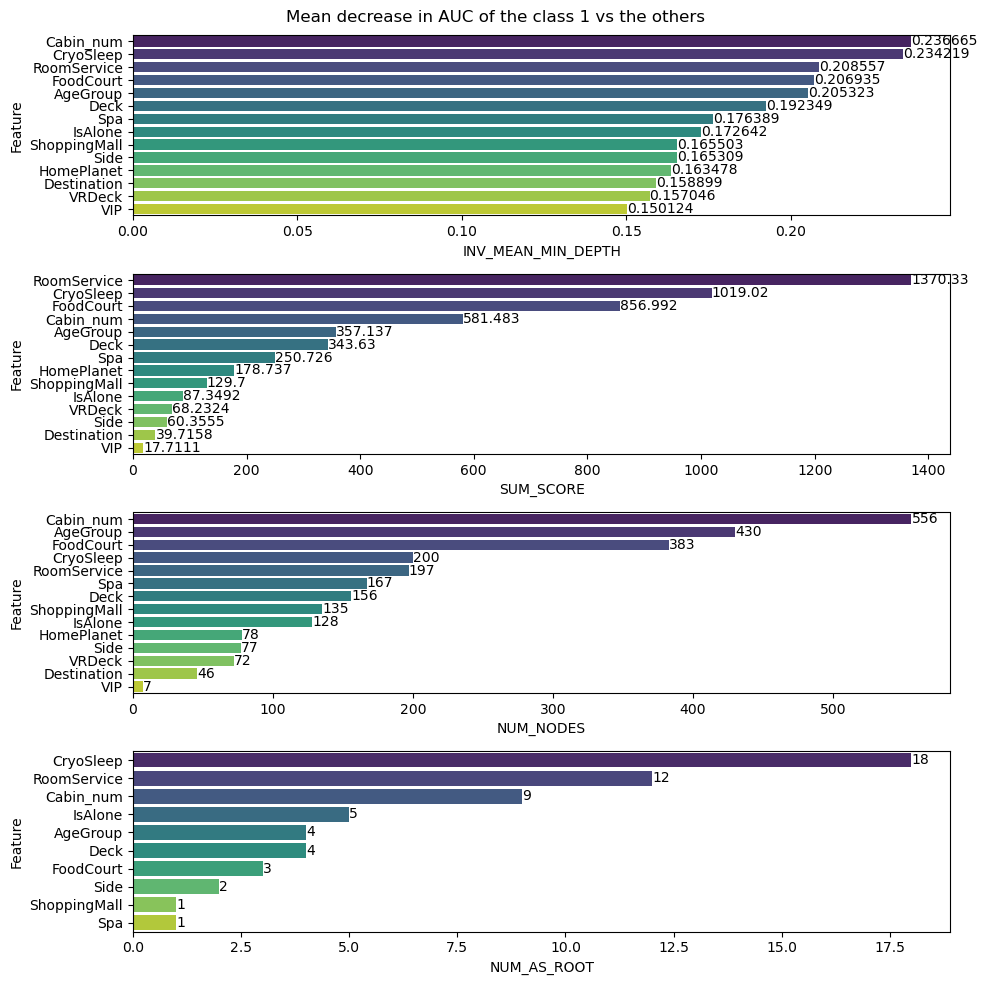

In [49]:
fig, ax = plt.subplots(4,1,  figsize=(10, 10))
fig.suptitle("Mean decrease in AUC of the class 1 vs the others")
plt.subplots_adjust(top = 2)

gbt_auto_variable_importance_metrics = list(gbt_auto_inspector.variable_importances().keys())

for i in range(len(gbt_auto_variable_importance_metrics)):
    # for metric in variable_importance_metrics
    gbt_auto_variable_importances = gbt_auto_inspector.variable_importances()[gbt_auto_variable_importance_metrics[i]]
    
    # `variable_importances` is a list of <feature, importance> tuples.
    gbt_auto_feature_names = [vi[0].name for vi in gbt_auto_variable_importances]
    gbt_auto_feature_importances = [vi[1] for vi in gbt_auto_variable_importances]
    # The feature are ordered in decreasing importance value.
    gbt_auto_feature_ranks = range(len(gbt_auto_feature_names))

    # Create a DataFrame to use with seaborn
    gbt_auto_importance_df = pd.DataFrame({'Feature': gbt_auto_feature_names, 'Importance': gbt_auto_feature_importances})

    # Plotting with seaborn barplot
    
    sns.barplot(gbt_auto_importance_df, y='Feature',x='Importance', orient='h', palette='viridis', ax=ax[i])
    ax[i].set_xlabel(gbt_auto_variable_importance_metrics[i])
    
    # Show the values on bars
    for j in ax[i].containers:
        ax[i].bar_label(j,)
    
plt.tight_layout()
plt.show()

#### Training logs for Auto-tuned GBT

Text(0, 0.5, 'Logloss (out-of-bag)')

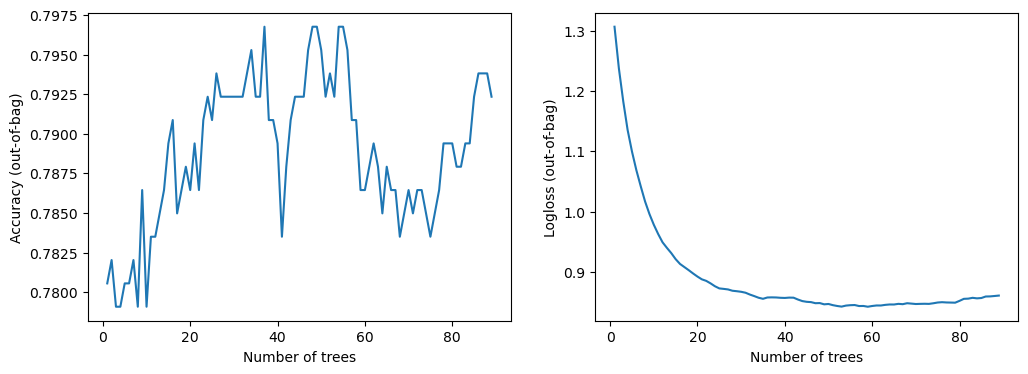

In [50]:
gbt_training_logs = gbt_auto_inspector.training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in gbt_training_logs], [log.evaluation.accuracy for log in gbt_training_logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in gbt_training_logs], [log.evaluation.loss for log in gbt_training_logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

#### Tuning logs for Auto-tuned GBT

In [51]:
# Display the tuning logs.
gbt_tuning_logs = gbt_auto.make_inspector().tuning_logs()

gbt_tuning_logs.head()

,score,evaluation_time,best,split_axis,sparse_oblique_projection_density_factor,sparse_oblique_normalization,sparse_oblique_weights,categorical_algorithm,growing_strategy,max_num_nodes,sampling_method,subsample,shrinkage,min_examples,use_hessian_gain,num_candidate_attributes_ratio,max_depth
0,-0.842269,26.106065,True,SPARSE_OBLIQUE,1.0,NONE,BINARY,CART,BEST_FIRST_GLOBAL,64.0,RANDOM,1.0,0.1,20,false,0.2,NaN
1,-0.868335,30.499154,False,SPARSE_OBLIQUE,5.0,MIN_MAX,BINARY,CART,BEST_FIRST_GLOBAL,32.0,RANDOM,1.0,0.1,10,false,0.2,NaN
2,-0.870871,40.633527,False,SPARSE_OBLIQUE,3.0,NONE,BINARY,RANDOM,LOCAL,NaN,RANDOM,1.0,0.1,5,false,0.5,8.0
3,-0.854839,66.970142,False,SPARSE_OBLIQUE,4.0,STANDARD_DEVIATION,CONTINUOUS,RANDOM,BEST_FIRST_GLOBAL,256.0,RANDOM,1.0,0.1,20,true,0.5,NaN
4,-0.878557,96.875839,False,SPARSE_OBLIQUE,3.0,STANDARD_DEVIATION,CONTINUOUS,CART,LOCAL,NaN,RANDOM,0.8,0.1,7,false,0.9,4.0


In [52]:
# Best hyper-parameters.
print(gbt_tuning_logs[gbt_tuning_logs.best].iloc[0])

score                                               -0.842269
evaluation_time                                     26.106065
best                                                     True
split_axis                                     SPARSE_OBLIQUE
sparse_oblique_projection_density_factor                  1.0
sparse_oblique_normalization                             NONE
sparse_oblique_weights                                 BINARY
categorical_algorithm                                    CART
growing_strategy                            BEST_FIRST_GLOBAL
max_num_nodes                                            64.0
sampling_method                                        RANDOM
subsample                                                 1.0
shrinkage                                                 0.1
min_examples                                               20
use_hessian_gain                                        false
num_candidate_attributes_ratio                            0.2
max_dept

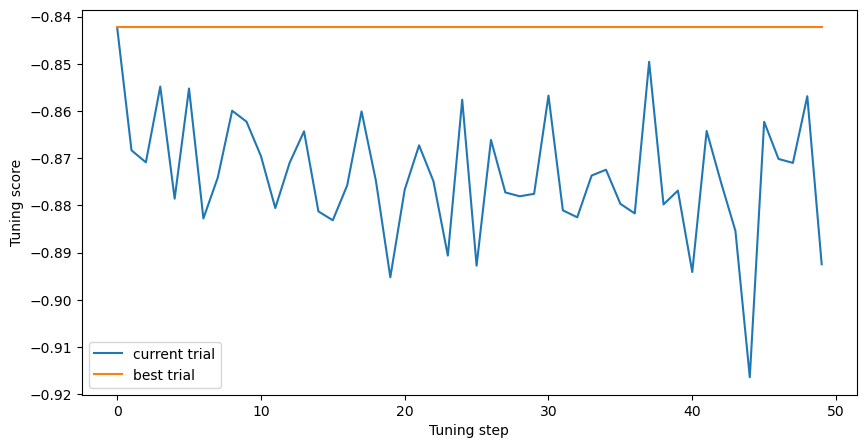

In [53]:
# plots
plt.figure(figsize=(10, 5))
plt.plot(gbt_tuning_logs["score"], label="current trial")
plt.plot(gbt_tuning_logs["score"].cummax(), label="best trial")
plt.xlabel("Tuning step")
plt.ylabel("Tuning score")
plt.legend()
plt.show()